In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
from urllib.error import URLError, HTTPError
from urllib.request import urlopen
from scipy.io import loadmat


def fetch_file(url):
    """Downloads a file from a URL.
    """
    try:
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        # Open our local file for writing
        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")

    #handle errors
    except HTTPError as e:
        print("HTTP Error:", e.code, url)
    except URLError as e:
        print("URL Error:", e.reason, url) 
        
url =  "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
data_filename = os.path.basename(url)
if not os.path.exists(data_filename):
    fetch_file(url)
else:
    print("Data file %s exists." % data_filename) 
    
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

Data file frey_rawface.mat exists.


In [3]:
# split data into train / validation folds
np.random.seed(42)
n_pixels = img_rows * img_cols
x_train = ff[:1800]
x_test = ff[1800:1900]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

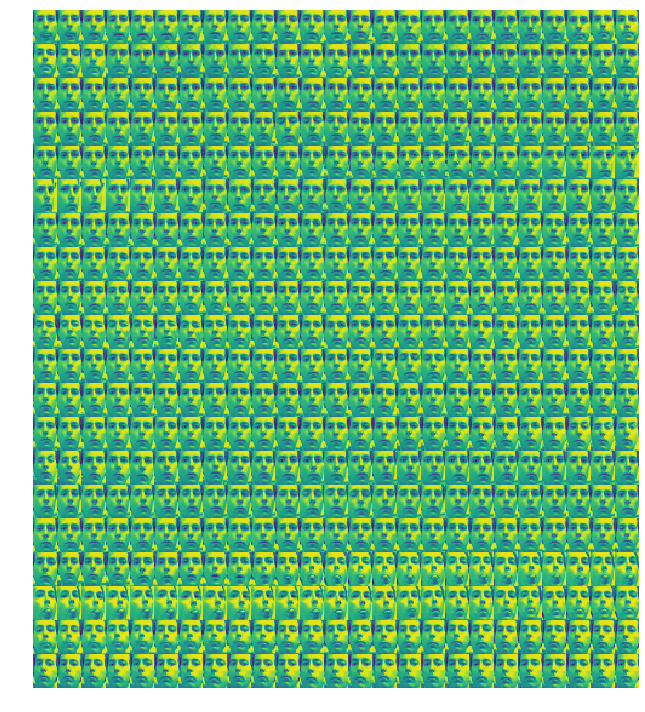

In [4]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=500, n_cols=25)

In [5]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [6]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [7]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    #filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    digit_size = 28
    img_rows, img_cols = 28, 20
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = z_m_m[latent_num] + xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    #plt.savefig(filename)
    plt.show()

In [8]:
from random import *
def plot_random_results(models,
                 latent_dim,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):


    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "face_over_latent.png")
    n = 10
    digit_size = 28
    img_rows, img_cols = 28, 20
    figure = np.zeros((img_rows * n , img_cols * n))
    
    #grid_x = np.linspace(-5, 5, n)
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
     
    
    for j in range(n):
        for k in range(n):
            z_sample[0,:] = z_m_m
            l = [x * 2 for x in [uniform(-1,1) for i in range(latent_dim)]]
            z_sample[0,:] += l
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_rows, img_cols)
            figure[k * img_rows : (k+1) * img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [9]:
[uniform(-1,1) for i in range(5)]

[-0.6495741856286823,
 -0.2265669276066764,
 -0.6990035884957606,
 -0.8895430827529038,
 -0.9679639251023486]

In [10]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 200
#intermediate_dim2 = 64
#intermediate_dim3 = 16

batch_size = 128
latent_dim = 3
epochs = 100

In [11]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x1)
#x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x1)
z_log_var = Dense(latent_dim, name='z_log_var')(x1)


In [14]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m
    return( z2)

z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [17]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

#x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(latent_inputs)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 560)               112560    
Total params: 113,360
Trainable params: 113,360
Non-trainable params: 0
_________________________________________________________________


In [18]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [19]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 560)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 113406    
_________________________________________________________________
decoder (Model)              (None, 560)               113360    
Total params: 226,766
Trainable params: 226,766
Non-trainable params: 0
_________________________________________________________________


In [20]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1800 samples, validate on 100 samples
Epoch 1/100
1800/1800 [==============================] - 1s 472us/step - loss: 380.3922 - val_loss: 370.8823
Epoch 2/100
1800/1800 [==============================] - 0s 63us/step - loss: 362.1781 - val_loss: 364.1995
Epoch 3/100
1800/1800 [==============================] - 0s 72us/step - loss: 355.0148 - val_loss: 362.6536
Epoch 4/100
1800/1800 [==============================] - 0s 69us/step - loss: 352.3953 - val_loss: 362.6409
Epoch 5/100
1800/1800 [==============================] - 0s 69us/step - loss: 351.3824 - val_loss: 359.9418
Epoch 6/100
1800/1800 [==============================] - 0s 69us/step - loss: 350.1924 - val_loss: 359.5675
Epoch 7/100
1800/1800 [==============================] - 0s 68us/step - loss: 349.6507 - val_loss: 361.5483
Epoch 8/100
1800/1800 [==============================] - 0s 69us/step - loss: 349.2828 - val_loss: 360.1731
Epoch 9/100
1800/1800 [==============================] - 0s 69us/step - loss: 348.9471 -

Epoch 76/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.9654 - val_loss: 359.0111
Epoch 77/100
1800/1800 [==============================] - 0s 70us/step - loss: 346.7805 - val_loss: 358.6057
Epoch 78/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.6620 - val_loss: 358.6440
Epoch 79/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.6754 - val_loss: 359.9182
Epoch 80/100
1800/1800 [==============================] - 0s 72us/step - loss: 346.7914 - val_loss: 361.6136
Epoch 81/100
1800/1800 [==============================] - 0s 71us/step - loss: 346.7213 - val_loss: 360.6407
Epoch 82/100
1800/1800 [==============================] - 0s 71us/step - loss: 346.6361 - val_loss: 359.2552
Epoch 83/100
1800/1800 [==============================] - 0s 66us/step - loss: 346.5822 - val_loss: 359.7899
Epoch 84/100
1800/1800 [==============================] - 0s 68us/step - loss: 346.6495 - val_loss: 360.6656
Epoch 85/100
1800/1

In [21]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input:0':x_test})

z_m_m = np.mean(z_output,axis=0)
z_m_m
#z_m_m[1]
#type(z_m_m)
np.zeros((1, 2 )) 
print(z_m_m)

np.cov(z_output.T)

[-0.10219448 -0.27715585 -0.27320305]


array([[ 1.01010096e+00,  7.39512636e-08, -1.97087372e-08],
       [ 7.39512636e-08,  1.01010071e+00,  1.69977541e-07],
       [-1.97087372e-08,  1.69977541e-07,  1.01010106e+00]])

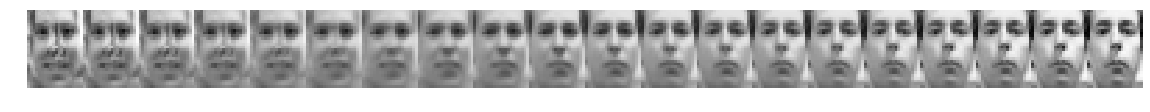

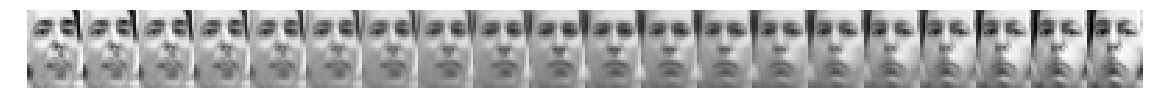

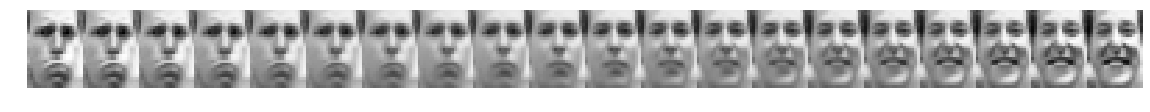

In [22]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [23]:
'''
plot_random_results(models,
                 latent_dim,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")
'''


'\nplot_random_results(models,\n                 latent_dim,\n                 z_m_m = z_m_m ,\n                 batch_size=batch_size,\n                 model_name="vae_mlp")\n'

In [24]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 200
#intermediate_dim2 = 64
#intermediate_dim3 = 16

batch_size = 128
latent_dim = 4
epochs = 100

In [25]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input_1')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x1)
#x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x1)
z_log_var = Dense(latent_dim, name='z_log_var')(x1)


In [26]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_1 (InputLayer)    (None, 560)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 200)          112200      encoder_input_1[0][0]            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            804         dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 4)            804         dense_4[0][0]                    
__________________________________________________________________________________________________
z_mean_std

In [27]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

#x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(latent_inputs)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               1000      
_________________________________________________________________
dense_6 (Dense)              (None, 560)               112560    
Total params: 113,560
Trainable params: 113,560
Non-trainable params: 0
_________________________________________________________________


In [28]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [29]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_1 (InputLayer) (None, 560)               0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 113808    
_________________________________________________________________
decoder (Model)              (None, 560)               113560    
Total params: 227,368
Trainable params: 227,368
Non-trainable params: 0
_________________________________________________________________


In [30]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1800 samples, validate on 100 samples
Epoch 1/100
1800/1800 [==============================] - 0s 267us/step - loss: 380.1225 - val_loss: 371.0218
Epoch 2/100
1800/1800 [==============================] - 0s 64us/step - loss: 361.5364 - val_loss: 362.7963
Epoch 3/100
1800/1800 [==============================] - 0s 71us/step - loss: 354.7394 - val_loss: 361.9388
Epoch 4/100
1800/1800 [==============================] - 0s 68us/step - loss: 352.3418 - val_loss: 362.0081
Epoch 5/100
1800/1800 [==============================] - 0s 68us/step - loss: 350.7278 - val_loss: 362.9183
Epoch 6/100
1800/1800 [==============================] - 0s 69us/step - loss: 349.8192 - val_loss: 360.4533
Epoch 7/100
1800/1800 [==============================] - 0s 69us/step - loss: 349.0692 - val_loss: 359.4847
Epoch 8/100
1800/1800 [==============================] - 0s 69us/step - loss: 348.5544 - val_loss: 359.3649
Epoch 9/100
1800/1800 [==============================] - 0s 72us/step - loss: 348.2839 -

Epoch 76/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.1420 - val_loss: 358.7011
Epoch 77/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.1146 - val_loss: 357.6318
Epoch 78/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.1602 - val_loss: 357.8959
Epoch 79/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.0593 - val_loss: 358.8458
Epoch 80/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.2162 - val_loss: 358.5559
Epoch 81/100
1800/1800 [==============================] - 0s 71us/step - loss: 346.1924 - val_loss: 358.5444
Epoch 82/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.0688 - val_loss: 359.4229
Epoch 83/100
1800/1800 [==============================] - 0s 72us/step - loss: 346.1319 - val_loss: 359.0612
Epoch 84/100
1800/1800 [==============================] - 0s 69us/step - loss: 346.1873 - val_loss: 360.1781
Epoch 85/100
1800/1

In [31]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input_1:0':x_test})
z_m_m = np.mean(z_output,axis=0)
z_m_m
#z_m_m[1]
#type(z_m_m)
np.zeros((1, 2 )) 
z_m_m


array([-0.27405703, -0.26771462,  0.16182533, -0.01360618], dtype=float32)

In [32]:
np.cov(z_output.T)

array([[ 1.01010097e+00, -2.56316495e-08,  6.45593171e-10,
         1.01033384e-07],
       [-2.56316495e-08,  1.01010121e+00, -6.36200083e-08,
        -1.02420100e-07],
       [ 6.45593171e-10, -6.36200083e-08,  1.01010114e+00,
         4.57727390e-08],
       [ 1.01033384e-07, -1.02420100e-07,  4.57727390e-08,
         1.01010087e+00]])

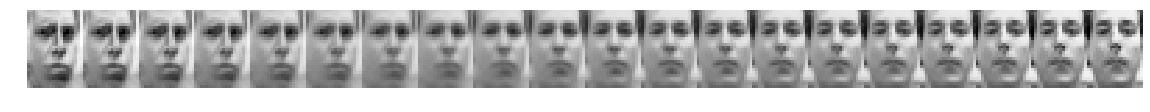

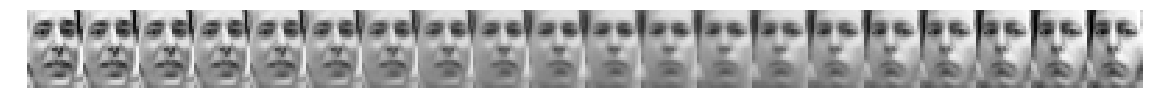

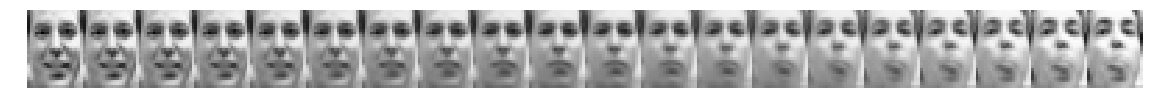

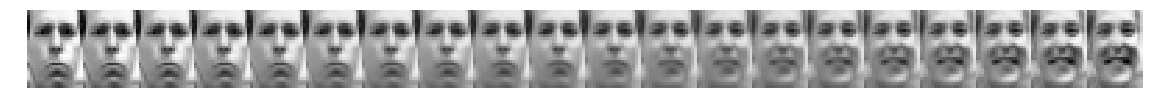

In [33]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [34]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 200
#intermediate_dim2 = 64
#intermediate_dim3 = 16

batch_size = 128
latent_dim = 5
epochs = 100

In [35]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input_2')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x1)
#x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x1)
z_log_var = Dense(latent_dim, name='z_log_var')(x1)


In [36]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_2 (InputLayer)    (None, 560)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 200)          112200      encoder_input_2[0][0]            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            1005        dense_7[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 5)            1005        dense_7[0][0]                    
__________________________________________________________________________________________________
z_mean_std

In [37]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

#x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
#x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(latent_inputs)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 560)               112560    
Total params: 113,760
Trainable params: 113,760
Non-trainable params: 0
_________________________________________________________________


In [38]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [39]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input_2 (InputLayer) (None, 560)               0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 114210    
_________________________________________________________________
decoder (Model)              (None, 560)               113760    
Total params: 227,970
Trainable params: 227,970
Non-trainable params: 0
_________________________________________________________________


In [40]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 1800 samples, validate on 100 samples
Epoch 1/100
1800/1800 [==============================] - 1s 350us/step - loss: 379.8773 - val_loss: 369.5258
Epoch 2/100
1800/1800 [==============================] - 0s 63us/step - loss: 360.4406 - val_loss: 362.3845
Epoch 3/100
1800/1800 [==============================] - 0s 71us/step - loss: 354.0453 - val_loss: 361.2140
Epoch 4/100
1800/1800 [==============================] - 0s 69us/step - loss: 351.5806 - val_loss: 358.4868
Epoch 5/100
1800/1800 [==============================] - 0s 71us/step - loss: 350.6528 - val_loss: 358.0554
Epoch 6/100
1800/1800 [==============================] - 0s 69us/step - loss: 349.6590 - val_loss: 357.4754
Epoch 7/100
1800/1800 [==============================] - 0s 71us/step - loss: 349.2397 - val_loss: 358.2639
Epoch 8/100
1800/1800 [==============================] - 0s 69us/step - loss: 348.5514 - val_loss: 358.6763
Epoch 9/100
1800/1800 [==============================] - 0s 69us/step - loss: 348.3698 -

Epoch 76/100
1800/1800 [==============================] - 0s 69us/step - loss: 345.7319 - val_loss: 359.2792
Epoch 77/100
1800/1800 [==============================] - 0s 68us/step - loss: 345.7347 - val_loss: 359.0282
Epoch 78/100
1800/1800 [==============================] - 0s 69us/step - loss: 345.7910 - val_loss: 360.2794
Epoch 79/100
1800/1800 [==============================] - 0s 71us/step - loss: 345.6986 - val_loss: 359.1084
Epoch 80/100
1800/1800 [==============================] - 0s 71us/step - loss: 345.6627 - val_loss: 359.9089
Epoch 81/100
1800/1800 [==============================] - 0s 70us/step - loss: 345.8321 - val_loss: 359.8166
Epoch 82/100
1800/1800 [==============================] - 0s 70us/step - loss: 345.8055 - val_loss: 359.5192
Epoch 83/100
1800/1800 [==============================] - 0s 71us/step - loss: 345.9084 - val_loss: 358.3956
Epoch 84/100
1800/1800 [==============================] - 0s 71us/step - loss: 345.9016 - val_loss: 359.0801
Epoch 85/100
1800/1

In [41]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input_2:0':x_test})
z_m_m = np.mean(z_output,axis=0)
z_m_m
#z_m_m[1]
#type(z_m_m)
#np.zeros((1, 2 )) 
z_m_m


array([ 0.408533  ,  0.17854305, -0.05688165,  0.01958308,  0.12527086],
      dtype=float32)

In [42]:
np.cov(z_output.T)

array([[ 1.01010093e+00,  1.50603536e-08,  1.12572324e-07,
         3.28917217e-08,  6.90655064e-08],
       [ 1.50603536e-08,  1.01010100e+00, -3.19339923e-08,
        -1.15280690e-08, -9.61633026e-08],
       [ 1.12572324e-07, -3.19339923e-08,  1.01010092e+00,
        -3.29998164e-08, -7.27657183e-08],
       [ 3.28917217e-08, -1.15280690e-08, -3.29998164e-08,
         1.01010093e+00, -5.20576552e-08],
       [ 6.90655064e-08, -9.61633026e-08, -7.27657183e-08,
        -5.20576552e-08,  1.01010058e+00]])

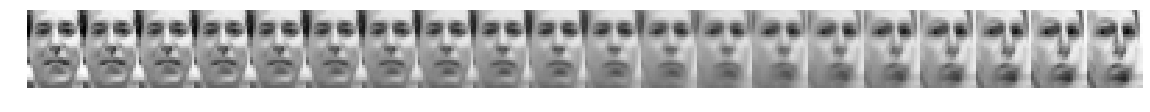

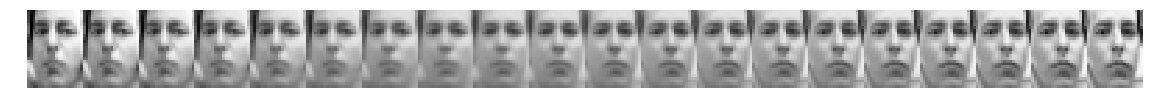

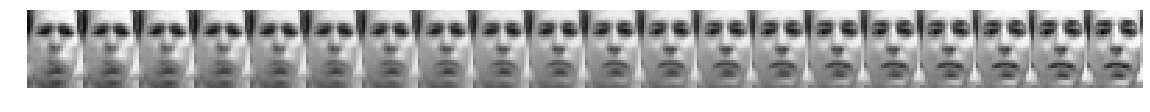

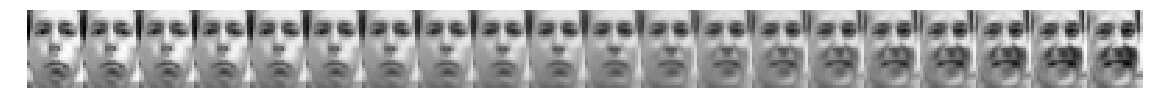

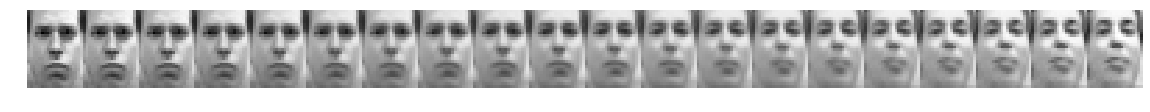

In [43]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")